In [6]:
# Import requirements for pipeline, data frame management, and plotting

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import math
import quantopian.research as qr

# The pipeline API requires imports.
from zipline.api import attach_pipeline, pipeline_output  #from quantopian.algorithm import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.data import USEquityPricing
from quantopian.research import prices # import prices function
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.factors import SimpleBeta
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import BusinessDaysSincePreviousEvent, Returns
from quantopian.research import run_pipeline
import alphalens as al
from quantopian.pipeline.classifiers.fundamentals import Sector

# Stocktwits data for possible sentiment analysis
from quantopian.pipeline.data.psychsignal import stocktwits

# Import all the built in Quantopian filters and factors (just in case)
import quantopian.pipeline.filters as Filters
import quantopian.pipeline.factors as Factors

In [22]:
def make_pipeline():
    
    # Set the base universe to QTradableStocksUS
    base_universe = QTradableStocksUS()
    
    
    # VALUE Factor - V
    ey = Fundamentals.earning_yield.latest
    bv = Fundamentals.book_value_yield.latest
    fcf = Fundamentals.fcf_yield.latest
    value = (ey+bv+fcf) / 3
    
    
    # GROWTH Factor - g
    # Custom Factor to find data at a previous PIT
    class Previous(CustomFactor):
        window_safe=True
        def compute(self, today, assets, out, inputs):  
            out[:] = inputs[0]
    
    # Building growth factor
    rev_curr = Fundamentals.total_revenue.latest  # latest total rev
    rev_1y = Previous(inputs = [Fundamentals.total_revenue], window_length = 252) # Total rev as of 252d ago
    rev_change = ((rev_curr-rev_1y)/rev_1y) # chg in tot rev from 1yr prev to today
    opinc_curr = Fundamentals.operating_income.latest # latest op inc
    opinc_1y = Previous(inputs = [Fundamentals.operating_income], window_length = 252) #op inc as of 252d
    opinc_change = ((opinc_curr - opinc_1y)/opinc_1y)
    sus_growth = Fundamentals.sustainable_growth_rate.latest
    growth = ((rev_change + opinc_change + sus_growth)/3)
    
    
    # MOMENTUM FACTOR - m
    pchg_1mo = ((USEquityPricing.close.latest /
                 Previous(inputs = [USEquityPricing.close], window_length = 21)) - 1.0)
    price_12mo_lag1 = (Previous(inputs = [USEquityPricing.close], window_length = 21) /
                       Previous(inputs = [USEquityPricing.close], window_length = 252)) - 1.0
    momentum = (pchg_1mo + price_12mo_lag1) / 2
    
    
    # MARKET Factor - K
    beta = SimpleBeta(target=qr.symbols('SPY'),regression_length=252)
    class StDevReturns(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 252
        def compute(self, today, assets, out, close):
            out[:] = np.nanstd(close, axis=0)
    std_dev = StDevReturns()
    market = (beta + std_dev / 2) * -1
    
    
    alpha = (value+growth+market+momentum)/4
    
    
    # Winsorize values for outlier smoothing
    value_w = value.winsorize(min_percentile=0.05, max_percentile=0.95, groupby=Sector())
    growth_w = growth.winsorize(min_percentile=0.05, max_percentile=0.95, groupby=Sector())
    momentum_w = momentum.winsorize(min_percentile=0.05, max_percentile=0.95, groupby=Sector())
    market_w = market.winsorize(min_percentile=0.05, max_percentile=0.95, groupby=Sector())
    alpha_w = alpha.winsorize(min_percentile=0.05, max_percentile=0.95, groupby=Sector())
    
    
    # Z score factors for cross sectional normalization
    value_z = value_w.zscore(groupby=Sector())
    growth_z = growth_w.zscore(groupby=Sector())
    momentum_z = momentum_w.zscore(groupby=Sector())
    market_z = market_w.zscore(groupby=Sector())
    alpha_z = alpha_w.zscore(groupby=Sector())
    
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=21,
    )
    
    
    top_bottom_alpha = (
        alpha_z.top(350) | alpha_z.bottom(350)
    )
    
    
    return Pipeline(
        columns={
            'Value': value_z,
            'Growth': growth_z,
            'Momentum': momentum_z,
            'Market': market_z,
            'Alpha': alpha_z,
            'Sentiment': sentiment_score
        },
        screen= base_universe & top_bottom_alpha
    )

pipe = make_pipeline()

sd = '2015'
ed = '2017'
result = run_pipeline(pipe,sd,ed)
result = result.dropna()
result.head()

Alpha    Growth    Market  \
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.220667 -0.103152 -1.083855   
                          Equity(24 [AAPL])  0.354684 -0.286834  0.751056   
                          Equity(31 [ABAX])  1.188201  1.538664  0.592205   
                          Equity(39 [DDC])   1.441763  0.947028  1.317011   
                          Equity(52 [ABM])   0.329050  0.099444  0.288150   

                                             Momentum  Sentiment     Value  
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])   1.743795   0.400000 -0.250677  
                          Equity(24 [AAPL])  1.368448   0.045714 -0.248720  
                          Equity(31 [ABAX])  0.709035   1.773810  0.361622  
                          Equity(39 [DDC])   1.082032   0.444286  0.274070  
                          Equity(52 [ABM])   0.150547   0.500000  0.422659

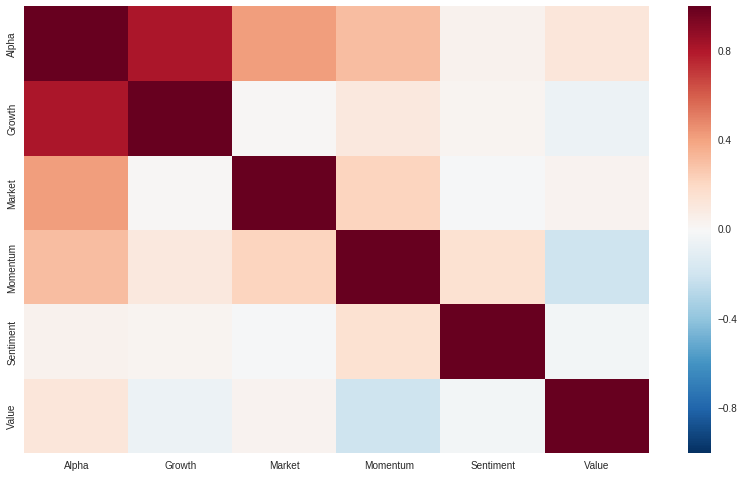

In [23]:
corr = result.corr()
sns.heatmap(corr)

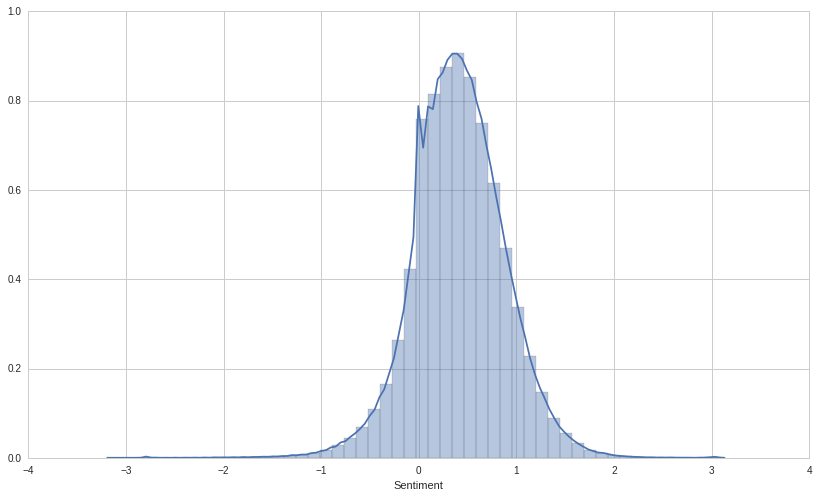

In [25]:
sns.distplot(result.Sentiment)

In [26]:
# Get list of unique assets from the pipeline output above
asset_list = result.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=sd,
    end=ed
)

In [38]:
# Use alphalens to test quality of selection strategy

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns( # this classifies our factor data into quantile
    factor=result['Alpha'],
    prices=asset_prices,
    quantiles=2,
    periods=(30,60,90), # computes forward returns for 1, 5, and 10 day holding periods for testing
)

# Display first 5 rows
factor_data.head(5)

Dropped 20.5% entries from factor data: 20.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


30D       60D       90D  \
date                      asset                                             
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.007667 -0.184925 -0.138258   
                          Equity(24 [AAPL])  0.173966  0.143109  0.162171   
                          Equity(31 [ABAX])  0.059605  0.113210 -0.095718   
                          Equity(39 [DDC])  -0.071585 -0.037776  0.135970   
                          Equity(52 [ABM])   0.060538  0.128077  0.127712   

                                               factor  factor_quantile  
date                      asset                                         
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.220667                1  
                          Equity(24 [AAPL])  0.354684                2  
                          Equity(31 [ABAX])  1.188201                2  
                          Equity(39 [DDC])   1.441763                2  
                          Equity(52 [ABM])   0.329050                2

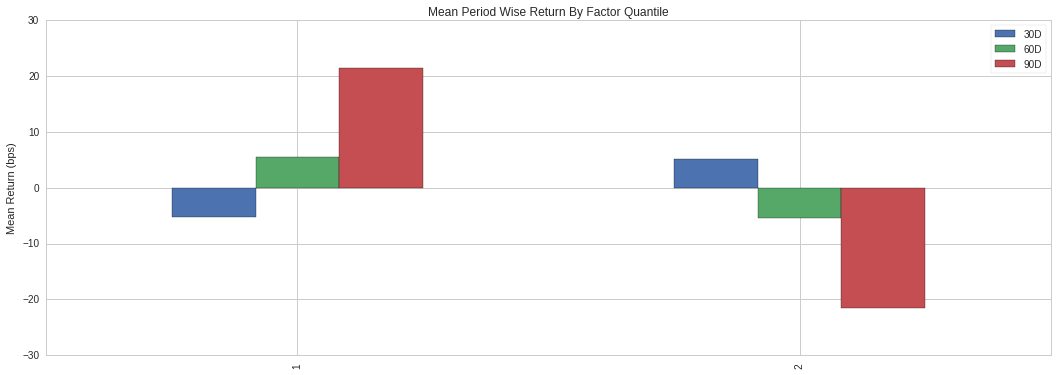

In [42]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('90D',)
    )
)

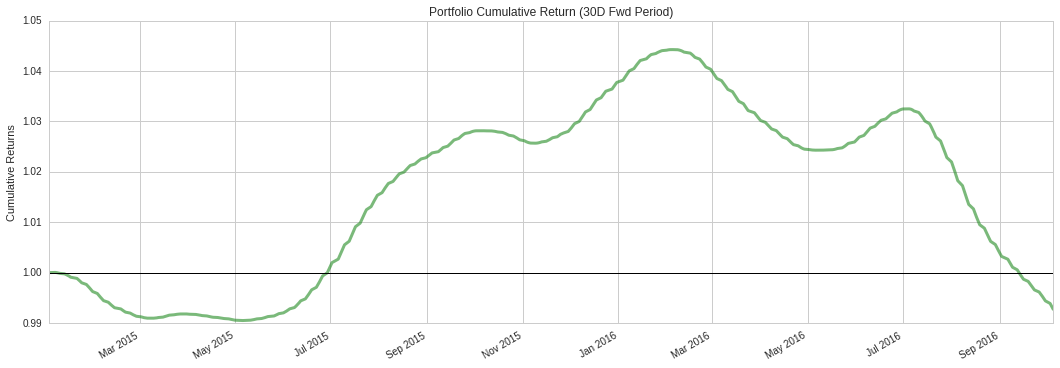

In [43]:
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 30 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['30D'], '30D')

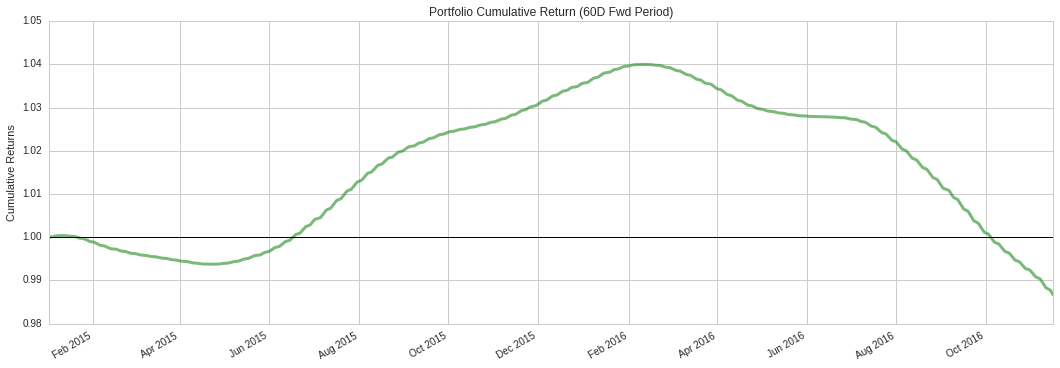

In [44]:
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 60 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['60D'], '60D')

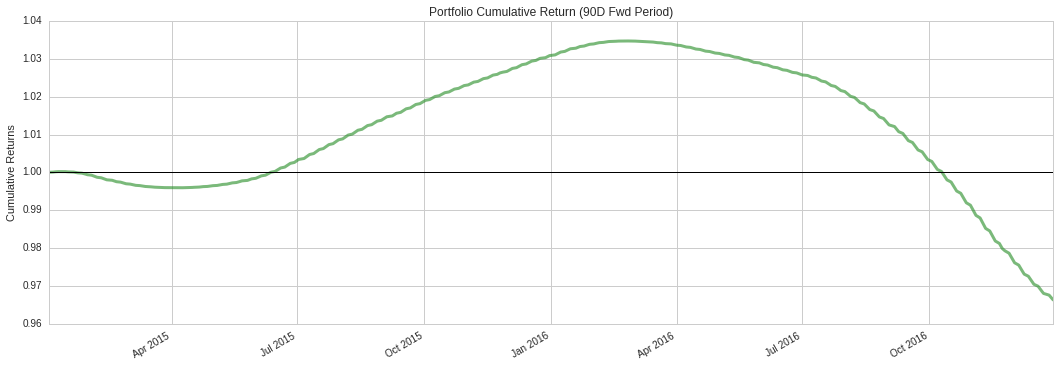

In [36]:
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 90 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['90D'], '90D')

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.687412,0.078278,-0.638147,0.655646,351129,50.014743
2,-0.152269,3.937764,0.500155,0.547214,350922,49.985257


Returns Analysis


,30D,60D,90D
Ann. alpha,0.008,0.006,0.004
beta,-0.152,-0.174,-0.219
Mean Period Wise Return Top Quantile (bps),1.734,-1.817,-7.193
Mean Period Wise Return Bottom Quantile (bps),-1.733,1.816,7.178
Mean Period Wise Spread (bps),1.924,-1.409,-8.370


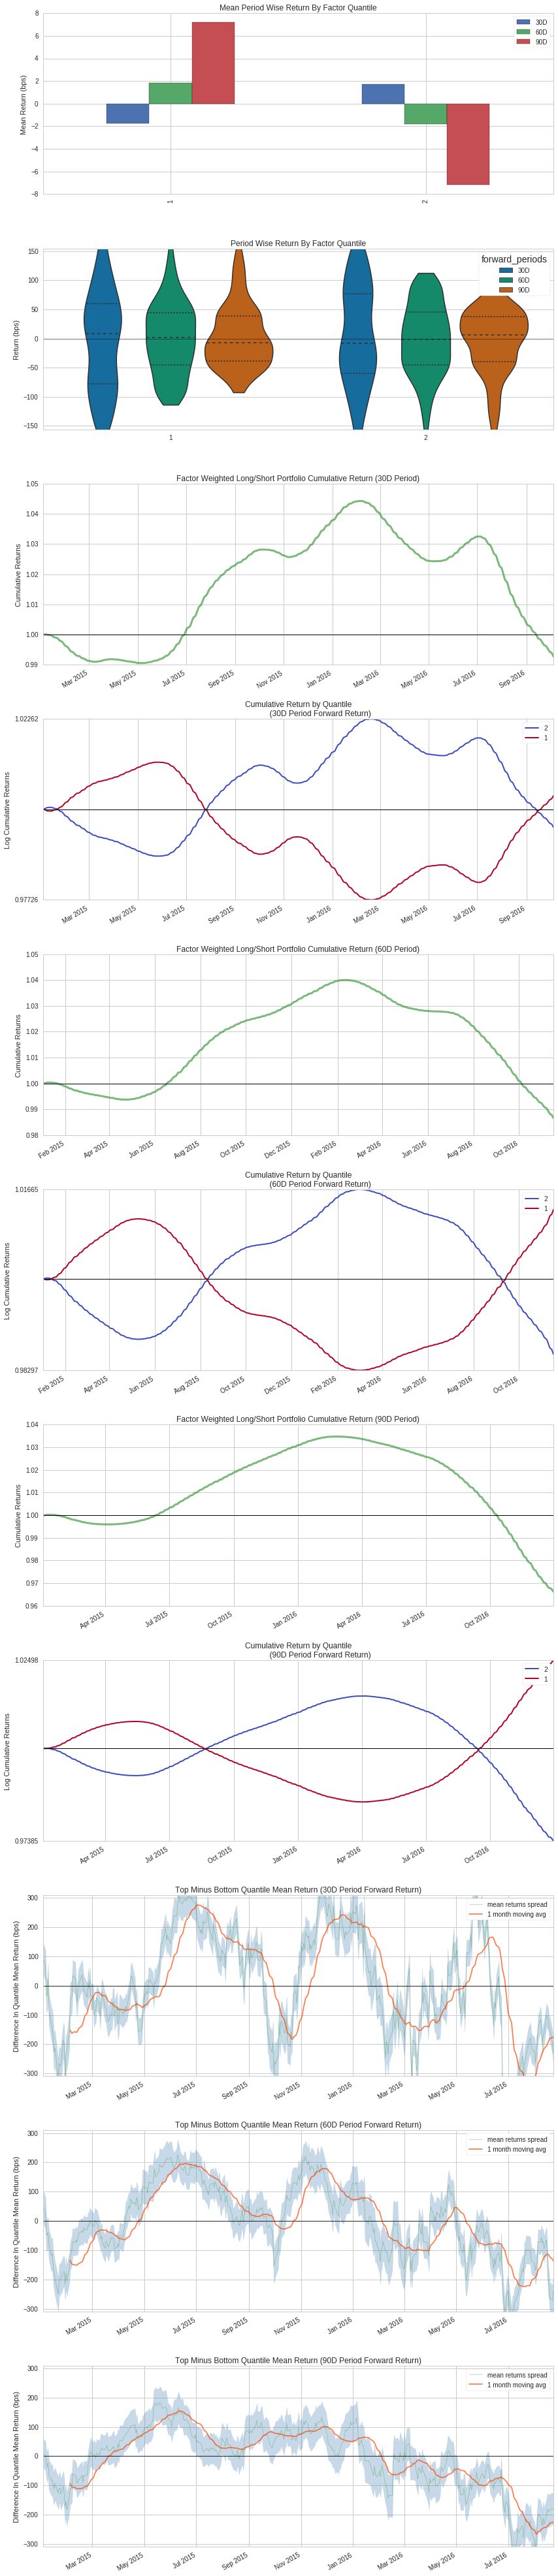

Information Analysis


,30D,60D,90D
IC Mean,0.002,-0.003,-0.007
IC Std.,0.102,0.099,0.102
Risk-Adjusted IC,0.017,-0.032,-0.066
t-stat(IC),0.349,-0.654,-1.338
p-value(IC),0.727,0.514,0.182
IC Skew,-0.240,-0.271,-0.582
IC Kurtosis,-0.734,-0.562,-0.154


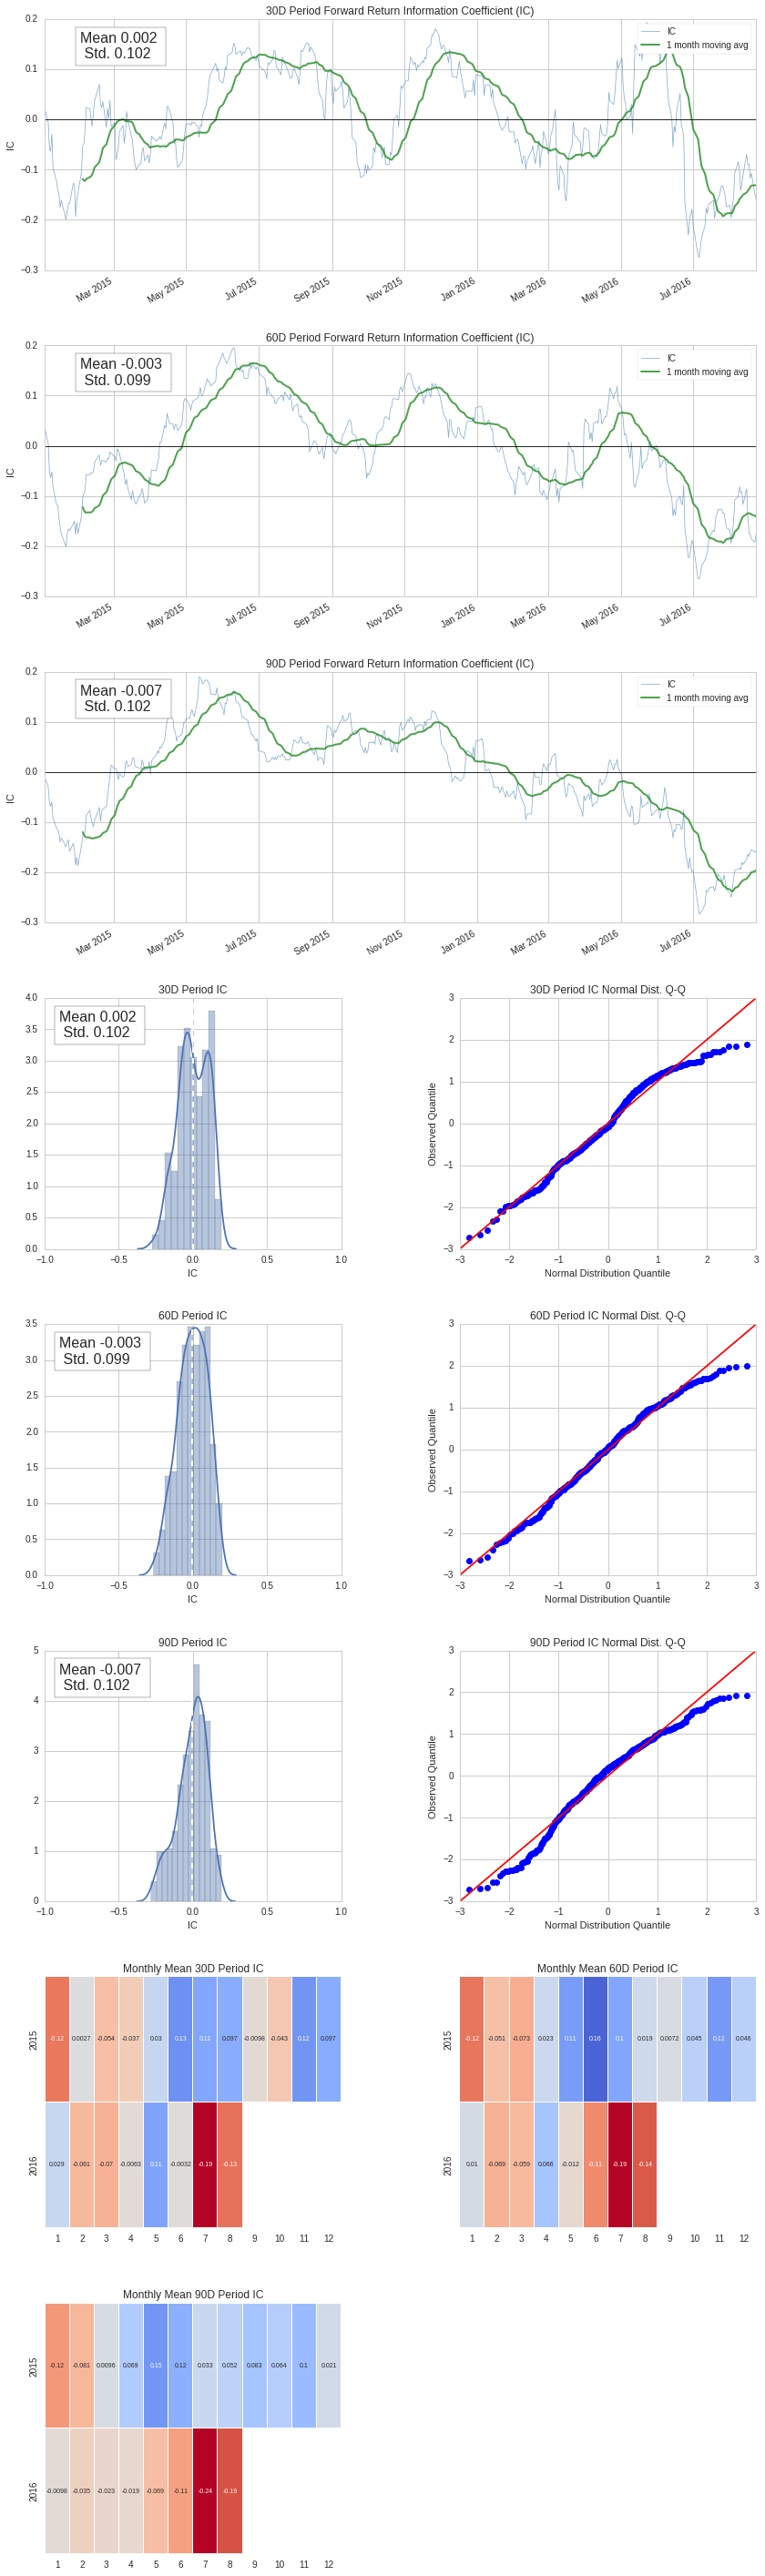

Turnover Analysis


,30D,60D,90D
Quantile 1 Mean Turnover,0.259,0.352,0.416
Quantile 2 Mean Turnover,0.256,0.351,0.411


,30D,60D,90D
Mean Factor Rank Autocorrelation,0.685,0.532,0.493


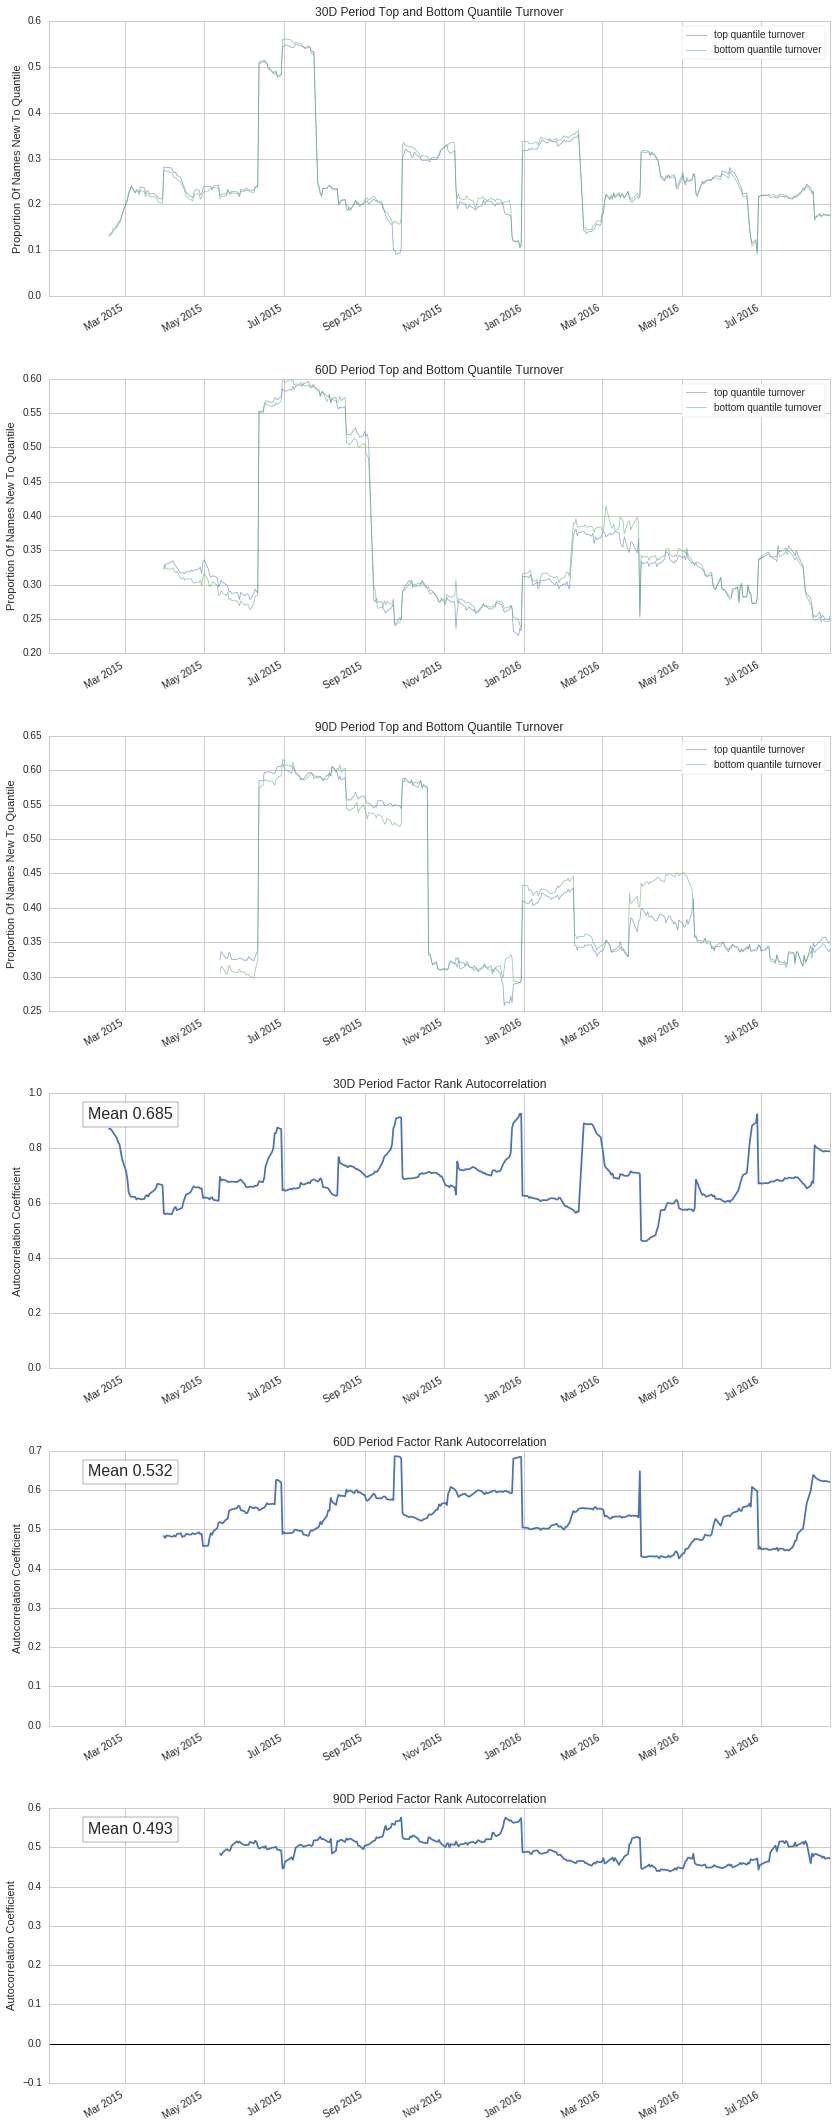

In [46]:
al.tears.create_full_tear_sheet(factor_data)